In [76]:
import matplotlib.pyplot as plt

import sys

sys.path.append("./")
sys.path.append("../../blackjax")

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 19

import jax
import blackjax
import numpy as np
import jax.numpy as jnp

def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda sqrt_diag_cov : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        sqrt_diag_cov=sqrt_diag_cov,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key

In [77]:
# logdensity_fn = lambda x: -0.5 * jnp.sum(jnp.square(x))

# b_hbar_omega = 15.8
# m_omega_over_hbar = 0.03
beta_hbar_omega = 15.8
m_omega_over_hbar = 0.03
m = 1.0
hbar = 1.0
omega = (m_omega_over_hbar * hbar) / m
beta = (beta_hbar_omega / (hbar * omega))


def V(xi):
    return 0.5 * m * (omega ** 2) * (jnp.linalg.norm(xi) ** 2)

@jax.jit
# -beta V_{eff}
# x.shape = (P,3)
def logdensity_fn(x):
    P = x.shape[0] - 1 # number of beads
    term1 = (m*P)/(2*(beta**2)*(hbar**2))*jnp.sum(jnp.array(
        [jnp.linalg.norm(x[i] - x[i+1])**2 for i in range(P)]))
    term2 = (V(x[0]) + V(x[-1]))/(2*P)
    term3 = jnp.sum(jax.vmap(V,in_axes=0)(x)[1:-1])/P

    # return -jnp.log(term1 + term2 + term3)
    return -beta*(term1 + term2 + term3)

sq = lambda x: x.dot(x)

@jax.jit
def logdensity_fn_fast(x):
    P = x.shape[0] - 1 # number of beads
    term1 = (m*P)/(2*(beta**2)*(hbar**2))*jnp.sum(jnp.array(
    jax.vmap(sq)(x[:-1,:]-x[1:,:]) ))
    term2 = (V(x[0]) + V(x[-1]))/(2*P)
    term3 = jnp.sum(jax.vmap(V,in_axes=0)(x)[1:-1])/P

    # return -jnp.log(term1 + term2 + term3)
    return -beta*(term1 + term2 + term3)


arr = jax.random.normal(jax.random.PRNGKey(0), (10, 3))
print(logdensity_fn_fast(arr))
print(logdensity_fn(arr))



-1.054393
-1.054393


In [78]:
num_steps = 200000
def transform(state, info):
    return ((state.position[-1] - state.position[0]))[0]

rng_key = jax.random.PRNGKey(0)

sample_key, rng_key = jax.random.split(rng_key)
samples, initial_state, params, chain_key = run_mclmc(
    logdensity_fn=logdensity_fn_fast,
    num_steps=num_steps,
    initial_position=jax.random.normal(sample_key, (400,3)),
    key=rng_key,
    transform=transform,
)
samples.mean()

Array(0.01671786, dtype=float32)

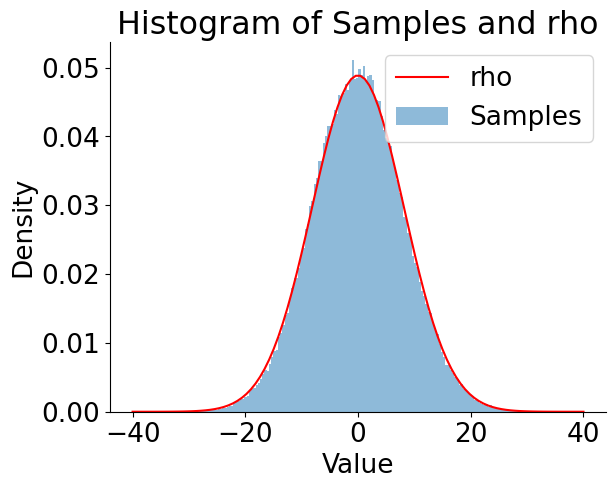

In [79]:
def rho(x):
    return jnp.sqrt((m*omega)/(4*jnp.pi*hbar*jnp.tanh(beta*hbar*omega / 2)))*jnp.exp((-m*omega*(x**2))/(4*hbar*jnp.tanh(beta*hbar*omega / 2)))

x = np.linspace(-40, 40, 100)
plt.plot(x, rho(x), color='red', label='rho')
plt.hist(samples, bins=180, density=True, alpha=0.5, label='Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Samples and rho')
plt.legend()
plt.show()


# plt.hist(samples, bins=60,density=True)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of Samples')
# plt.show()

In [63]:
beta_hbar_omega = 15.8
m_omega_over_hbar = 0.03
m = 1.0
hbar = 1.0
omega = (m_omega_over_hbar * hbar) / m
beta = (beta_hbar_omega / (hbar * omega))

def mod_index(arr, i):
    return arr[i % (arr.shape[0])]

@jax.jit
def logdensity_fn(x):
    P = x.shape[0] # number of beads
    term1 = (m*P)/(2*(beta**2)*(hbar**2))*jnp.sum(jnp.array(
        [jnp.linalg.norm(mod_index(x, i) - mod_index(x,i+1))**2 for i in range(P)]))
    term2 = jnp.sum(jax.vmap(V,in_axes=0)(x))/P

    # return -jnp.log(term1 + term2 + term3)
    return -beta*(term1 + term2)


num_steps = 100000
def transform(state, info):
    x = state.position
    P = x.shape[0]
    return (1/P)*jnp.sum(jnp.array([(1/2)*mod_index(x, i)*mod_index(jax.grad(V)(x),i) + V(mod_index(x, i)) for i in range(P)]))

rng_key = jax.random.PRNGKey(0)

sample_key, rng_key = jax.random.split(rng_key)
samples, initial_state, params, chain_key = run_mclmc(
    logdensity_fn=logdensity_fn,
    num_steps=num_steps,
    initial_position=jax.random.normal(sample_key, (40,1)),
    key=rng_key,
    transform=transform,
    # desired_energy_variance=0.0005
)
samples.mean()


Array(0.01447558, dtype=float32)

/var/folders/v9/977m2z015_b794hqf_nk0q1r0000gn/T/ipykernel_10101/2441073857.py:2: RuntimeWarning: Mean of empty slice.
  y = [(samples[:i].mean()) / (hbar * omega / 2) for i in range( num_steps)]
/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


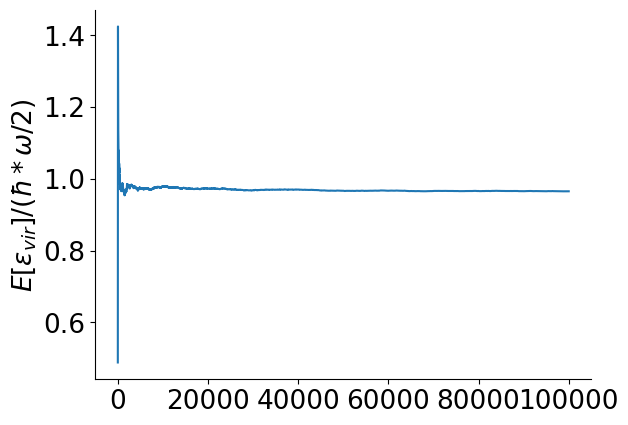

In [72]:
samples = np.array(samples)
y = [(samples[:i].mean()) / (hbar * omega / 2) for i in range( num_steps)]
plt.ylabel('$E[\epsilon_{vir}] / (\hbar * \omega / 2)$')
plt.plot(y)

In [ ]:
# 
samples[:].mean() / (hbar * omega /2)


0.9650385628143947